# Prevendo vendas de shampoo


Agora vamos praticar em python como criar um modelo ARIMA.

Vamos analisar um dataset que contém vendas de shampoo durante um período de 3 anos. As unidades são vendas e ele possui 36 observações.

In [17]:
#Primeiramente vamos importar as bibliotecas que iremos utilizar


import pandas as pd
import matplotlib as mtpl
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


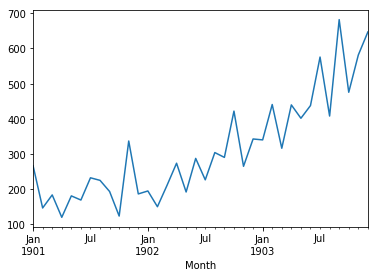

In [18]:
#função para tratar campo data
def parser(x):
    return pd.datetime.strptime('190'+x, '%Y-%m')

#Agora vamos importar nosso arquivo 
series = pd.read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head())
series.plot()
mtpl.pyplot.show()


Podemos ver que o conjunto de dados de vendas de shampoo tem uma tendência clara.

Isso sugere que a série temporal não é estacionária e exigirá diferenciação para torná-la estacionária, pelo menos na ordem de 1.

Vamos também dar uma olhada rápida em um gráfico de autocorrelação da série temporal. Isso pode ser feito usando o Pandas. O exemplo abaixo plota a autocorrelação para um grande número de lags na série temporal.

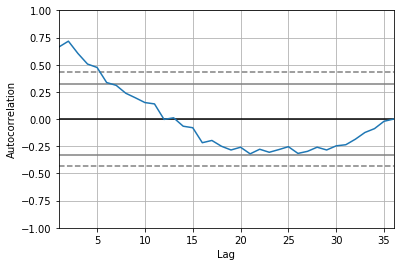

In [19]:
pd.plotting.autocorrelation_plot(series)
mtpl.pyplot.show()

Executando o exemplo, podemos ver que há uma correlação positiva com os primeiros 10 a 12 lags que talvez seja significativa apenas para os 5 primeiros.

Um bom ponto de partida para o parâmetro AR do modelo pode ser 5


# ARIMA com Python

A biblioteca statsmodels fornece a capacidade de ajustar um modelo ARIMA.

Um modelo ARIMA pode ser criado usando a biblioteca statsmodels da seguinte maneira:

Defina o modelo chamando ARIMA () e passando os parâmetros p, d e q.
O modelo é preparado nos dados de treinamento chamando a função fit ().
As previsões podem ser feitas chamando a função predict () e especificando o índice da hora ou horas a serem previstas.
Vamos começar com algo simples. Ajustaremos um modelo ARIMA a todo o conjunto de dados de vendas de shampoo e revisaremos os erros residuais.

Primeiro, ajustamos um modelo ARIMA (5,1,0). Isso define o valor do atraso como 5 para regressão automática, usa uma ordem de diferença de 1 para tornar a série temporal estacionária e usa um modelo de média móvel de 0.

Ao ajustar o modelo, são fornecidas muitas informações de depuração sobre o ajuste do modelo de regressão linear. Podemos desativar isso definindo o argumento disp como 0

In [20]:
# fit modelo
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())



                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   35
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -196.170
Method:                       css-mle   S.D. of innovations             64.241
Date:                Sat, 26 Oct 2019   AIC                            406.340
Time:                        11:08:48   BIC                            417.227
Sample:                    02-01-1901   HQIC                           410.098
                         - 12-01-1903                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.0649      3.652      3.304      0.003       4.908      19.222
ar.L1.D.Sales    -1.1082      0.183     -6.063      0.000      -1.466      -0.750
ar.L2.D.Sales    -0.6203      0.282     

/Users/talitabarcelos/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  # Now, if no frequency information is available from the index
/Users/talitabarcelos/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  # also a given frequency, raise an exception if they are not
/Users/talitabarcelos/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  # Now, if no frequency information is available from the index


A execução do exemplo imprime um resumo do modelo de ajuste. Isso resume os valores do coeficiente usados, bem como a habilidade do ajuste nas observações na amostra.

Primeiro, obtemos um gráfico de linha dos erros residuais, sugerindo que ainda pode haver algumas informações de tendência não capturadas pelo modelo.

Em seguida, obtemos um gráfico de densidade dos valores de erro residual, sugerindo que os erros são gaussianos, mas podem não estar centrados no zero.

A distribuição dos erros residuais é exibida. Os resultados mostram que, de fato, existe um viés na predição (média não zerada no residual)

Observe que, embora acima tenhamos usado todo o conjunto de dados para análise de séries temporais, o ideal seria realizar essa análise apenas no conjunto de dados de treinamento ao desenvolver um modelo preditivo.

A seguir, veremos como podemos usar o modelo ARIMA para fazer previsões.

# Modelo ARIMA de previsão contínua

O modelo ARIMA pode ser usado para prever futuro

Podemos usar a função predict () no objeto ARIMAResults para fazer previsões. Ele aceita o índice das etapas de tempo para fazer previsões como argumentos. Esses índices são relativos ao início do conjunto de dados de treinamento usado para fazer previsões.

Se usamos 100 observações no conjunto de dados de treinamento para ajustar-se ao modelo, o índice da próxima etapa para fazer uma previsão será especificado para a função de previsão como start = 101, end = 101. Isso retornaria uma matriz com um elemento contendo a previsão.

Também preferimos que os valores previstos estejam na escala original, caso realizemos alguma diferença (d> 0 ao configurar o modelo). Isso pode ser especificado configurando o argumento de tipo com o valor 'levels': typ = 'levels'.

Como alternativa, podemos evitar todas essas especificações usando a função forecast (), que executa uma previsão em uma etapa usando o modelo.

Podemos dividir o conjunto de dados de treinamento em conjuntos de treinamento e teste, usar o conjunto de treinamento para ajustar-se ao modelo e gerar uma previsão para cada elemento no conjunto de teste.

É necessária uma previsão contínua, dada a dependência das observações em etapas anteriores para diferenciar e o modelo de AR. Uma maneira grosseira de executar essa previsão contínua é recriar o modelo ARIMA após cada nova observação ser recebida.

Nós mantemos o controle manual de todas as observações em uma lista chamada histórico que é semeada com os dados de treinamento e à qual novas observações são anexadas a cada iteração.

Juntando tudo isso, abaixo está um exemplo de uma previsão contínua com o modelo ARIMA em Python.

predicted=349.117636, expected=342.300000
predicted=306.513010, expected=339.700000
predicted=387.376466, expected=440.400000
predicted=348.154255, expected=315.900000
predicted=386.308811, expected=439.300000
predicted=356.082028, expected=401.300000
predicted=446.379518, expected=437.400000
predicted=394.737242, expected=575.500000
predicted=434.915541, expected=407.600000
predicted=507.923456, expected=682.000000
predicted=435.482818, expected=475.300000
predicted=652.743768, expected=581.300000
predicted=546.343465, expected=646.900000
Test MSE: 6958.327


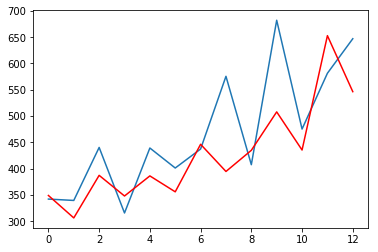

In [16]:
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
mtpl.pyplot.plot(test)
mtpl.pyplot.plot(predictions, color='red')
mtpl.pyplot.show()







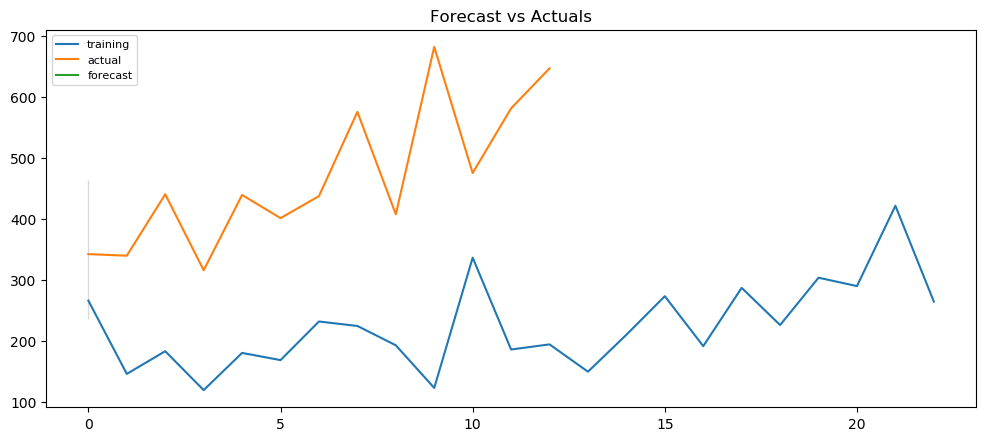

In [33]:
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
# Cria Modelo
# modelo = ARIMA(train, order=(3,2,1))  
model = ARIMA(history, order=(5, 1, 0))  
fitted = model.fit(disp=-1)  

# Cria Training and Test set
train = df.value[:85]
test = df.value[85:]

# Cria Modelo
# modelo = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Previsao
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf



# Previsao
fc, se, conf = fitted.forecast()  

# Cria pandas dataframa
fc_series = pd.Series(fc)
lower_series = pd.Series(conf[:, 0])
upper_series = pd.Series(conf[:, 1])


# Plota
mtpl.pyplot.figure(figsize=(12,5), dpi=100)
mtpl.pyplot.plot(train, label='training')
mtpl.pyplot.plot(test, label='actual')
mtpl.pyplot.plot(fc_series, label='forecast')
mtpl.pyplot.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
mtpl.pyplot.title('Forecast vs Actuals')
mtpl.pyplot.legend(loc='upper left', fontsize=8)
mtpl.pyplot.show()

A execução do exemplo imprime a previsão e o valor esperado a cada iteração.

Também podemos calcular uma pontuação média de erro quadrático final (MSE) para as previsões, fornecendo um ponto de comparação para outras configurações do ARIMA.

É criado um gráfico de linhas mostrando os valores esperados (azul) em comparação com as previsões de previsão sem interrupção (vermelho). Podemos ver que os valores mostram alguma tendência e estão na escala correta.

Neste exercicio,aprendemos como desenvolver um modelo ARIMA para previsão de séries temporais no Python.

Você aprendeu especificamente:

Sobre o modelo ARIMA, como ele pode ser configurado e suposições feitas pelo modelo.
Como executar uma análise rápida de séries temporais usando o modelo ARIMA.
Como usar um modelo ARIMA para prever previsões fora da amostra.